# Distributed Ridge Regression
## Parameter Definition and Centralized Optimization
The problem is defined as

$$
\min_{x \in \mathbb{R}^d} \quad \frac{1}{4} \sum_{i = 1}^4 (u_i^\top x - v_i)^2 + \rho \| x \|^2
$$

where the solution is denoted as $x^*$.

In [1]:
import numpy as np
import numpy.typing as npt

if __name__ == "__main__":
    dim = 10

    # Should be consistent with the definition in the graph server
    import logging
    from topolink import Graph, bootstrap

    logging.basicConfig(level=logging.INFO)

    L = np.array([[2, -1, 0, -1], [-1, 2, -1, 0], [0, -1, 2, -1], [-1, 0, -1, 2]])
    W = np.eye(4) - L * 0.2

    graph = Graph.from_mixing_matrix(W, transport="tcp")
    n_nodes = graph.number_of_nodes
    nodes = [str(i) for i in range(1, n_nodes + 1)]

    import numpy.random as npr

    npr.seed(0)

    rho = 0.01
    u = {i: npr.uniform(-1, 1, dim) for i in nodes}
    x_tilde = {i: np.multiply(0.1 * (int(i) - 1), np.ones(dim)) for i in nodes}
    epsilon = {i: npr.normal(0, 5) for i in nodes}
    v = {i: u[i] @ x_tilde[i] + epsilon[i] for i in nodes}

    import cvxpy as cp

    x = cp.Variable(dim)

    loss = cp.sum([(u[i] @ x - v[i]) ** 2 for i in nodes]) / n_nodes
    regularizer = rho * cp.sum_squares(x)

    prob = cp.Problem(cp.Minimize(loss + regularizer))
    prob.solve(cp.OSQP)

    x_star: npt.NDArray[np.float64] = x.value  # type: ignore

    print(f"Optimal solution: {x_star}")

Optimal solution: [-0.92907018  1.82395728 -2.34861204 -1.14665289 -2.47729986  3.64587729
  2.57938462 -2.66468855 -3.83712911 -0.87901971]


## Benchmarking Distributed Optimization Algorithms

In this section, we benchmark the distributed optimization algorithms `EXTRA`, `NIDS`, `DIGing`, `AugDGM`, `WE`, and `RGT` on the ridge regression problem.
Each algorithm is executed with its respective step size, and their performance is compared in terms of mean squared error (MSE)

$$
\frac{1}{4d} \sum_{i = 1}^{4} || x_i - x^* ||^2
$$

over iterations, where $x_i, x^* \in \mathbb{R}^d$.

The network topology is a ring, and the gossip matrix is defined as $W = I - 0.2L$, with $L$ being the Laplacian matrix of the graph.

In [ ]:
import dask.distributed as dd


def ridge_regression(
    node_id: str,
    dimension: int,
    u_i: npt.NDArray[np.float64],
    v_i: npt.NDArray[np.float64],
    rho_i: float,
    gamma: float,
    optimizer_name: str,
) -> npt.NDArray[np.float64]:
    import numpy as np

    max_iter = 2000
    x_i = np.zeros((max_iter, dimension), dtype=np.float64)

    # Define loss function
    def f(var: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        return (u_i @ var - v_i) ** 2 + rho_i * var @ var

    # Define node handle with masking
    from numpy.random import normal
    from topolink import NodeHandle

    class Tranform:
        def encode(
            self, state: npt.NDArray[np.float64]
        ) -> tuple[bytes, npt.NDArray[np.float64]]:
            noise = normal(0, 0.01, state.shape)
            return b"", state + noise

        def decode(self, meta: bytes, payload: bytes) -> npt.NDArray[np.float64]:
            return np.frombuffer(payload, dtype=np.float64)

    nh = NodeHandle(node_id, transform=Tranform(), transport="tcp")

    # Create optimizer and run iterations
    from dco import get_optimizer

    optimizer = get_optimizer(optimizer_name)(f, nh, gamma)

    optimizer.init(x_i[0])

    for k in range(max_iter - 1):
        x_i[k + 1] = optimizer.step(x_i[k])

    return x_i


if __name__ == "__main__":
    step_sizes = {
        "EXTRA": 0.16,
        "NIDS": 0.21,
        "DIGing": 0.11,
        "AugDGM": 0.31,
        "WE": 0.17,
        "RGT": 0.11,
    }

    local_histories: dict[str, list[npt.NDArray[np.float64]]] = {}

    import os
    import dotenv
    import pathlib

    ROOT_DIR = pathlib.Path.cwd().parent.resolve()

    # Load environment variables
    # Use your own .env file to set DASK_CLIENT
    dotenv.load_dotenv(ROOT_DIR / ".env")
    DASK_CLIENT = os.getenv("DASK_CLIENT")

    client = dd.Client(DASK_CLIENT)

    for alg, gam in step_sizes.items():
        bootstrap(graph)

        futures = [
            client.submit(ridge_regression, i, dim, u[i], v[i], rho, gam, alg)
            for i in nodes
        ]

        local_histories[alg] = [future.result() for future in futures]

        print(f"Algorithm: {alg}, Step size: {gam}, Finished!")

    client.close()

INFO:topolink.graph:Graph 'default' running on: 192.168.1.112:46341
INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '4' joined graph 'default' from 192.168.1.112:45521.
INFO:topolink.graph:Node '3' joined graph 'default' from 192.168.1.111:34561.
INFO:topolink.graph:Node '2' joined graph 'default' from 192.168.1.106:36567.
INFO:topolink.graph:Node '1' joined graph 'default' from 192.168.1.107:34523.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor info to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topolink.graph:Graph 'default' running on: 192.168.1.112:44839


Algorithm: EXTRA, Step size: 0.16, Finished!


INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '3' joined graph 'default' from 192.168.1.112:45055.
INFO:topolink.graph:Node '2' joined graph 'default' from 192.168.1.111:46419.
INFO:topolink.graph:Node '1' joined graph 'default' from 192.168.1.111:33239.
INFO:topolink.graph:Node '4' joined graph 'default' from 192.168.1.107:42927.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor info to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topolink.graph:Graph 'default' running on: 192.168.1.112:45925


Algorithm: NIDS, Step size: 0.21, Finished!


INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '4' joined graph 'default' from 192.168.1.112:44807.
INFO:topolink.graph:Node '3' joined graph 'default' from 192.168.1.111:40633.
INFO:topolink.graph:Node '2' joined graph 'default' from 192.168.1.106:46701.
INFO:topolink.graph:Node '1' joined graph 'default' from 192.168.1.103:36909.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor info to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topolink.graph:Graph 'default' running on: 192.168.1.112:45983


Algorithm: DIGing, Step size: 0.11, Finished!


INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '3' joined graph 'default' from 192.168.1.112:45579.
INFO:topolink.graph:Node '1' joined graph 'default' from 192.168.1.111:38681.
INFO:topolink.graph:Node '2' joined graph 'default' from 192.168.1.111:38815.
INFO:topolink.graph:Node '4' joined graph 'default' from 192.168.1.110:41431.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor info to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topolink.graph:Graph 'default' running on: 192.168.1.112:46595


Algorithm: AugDGM, Step size: 0.31, Finished!


INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '1' joined graph 'default' from 192.168.1.112:45031.
INFO:topolink.graph:Node '2' joined graph 'default' from 192.168.1.112:45057.
INFO:topolink.graph:Node '3' joined graph 'default' from 192.168.1.107:39785.
INFO:topolink.graph:Node '4' joined graph 'default' from 192.168.1.103:44219.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor info to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'
INFO:topolink.graph:Graph 'default' running on: 192.168.1.112:46205


Algorithm: WE, Step size: 0.17, Finished!


INFO:topolink.discovery:Registered graph service with name 'default'
INFO:topolink.graph:Node '4' joined graph 'default' from 192.168.1.111:41501.
INFO:topolink.graph:Node '2' joined graph 'default' from 192.168.1.110:40183.
INFO:topolink.graph:Node '1' joined graph 'default' from 192.168.1.106:37225.
INFO:topolink.graph:Node '3' joined graph 'default' from 192.168.1.103:39035.
INFO:topolink.graph:Graph 'default' registration complete.
INFO:topolink.graph:Sent neighbor info to all nodes in graph 'default'.
INFO:topolink.discovery:Unregistered graph service with name 'default'


Algorithm: RGT, Step size: 0.11, Finished!


## Plot results

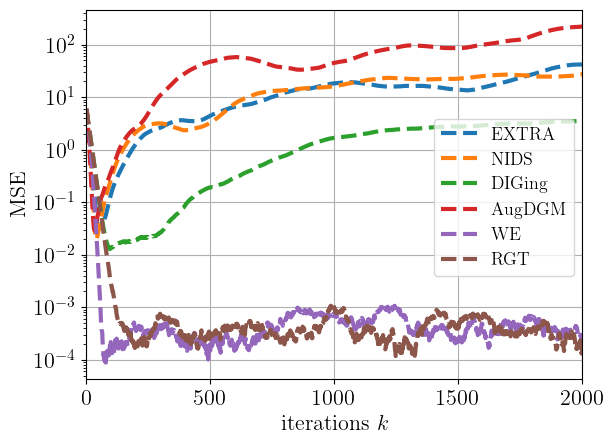

In [3]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from numpy import mean, stack

    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "serif"

    plt.rcParams.update(
        {
            "font.size": 14,
            "axes.titlesize": 16,
            "axes.labelsize": 16,
            "xtick.labelsize": 16,
            "ytick.labelsize": 16,
            "legend.fontsize": 13,
        }
    )

    fig, ax = plt.subplots()

    line_options = {"linewidth": 3, "linestyle": "--"}

    hh: list[npt.NDArray[np.float64]] = []

    for algorithm, histories in local_histories.items():
        # shape: (n_nodes, n_iter, dim)
        stacked_histories = stack(histories)
        # shape: (n_nodes, n_iter)
        mse_evolution_nodes = mean((stacked_histories - x_star) ** 2, axis=2)
        mse_evolution = mean(mse_evolution_nodes, axis=0)
        ax.semilogy(mse_evolution, label=algorithm, **line_options)
        hh.append(mse_evolution)

    ax.set_xlim((0, 2000))
    ax.set_xlabel("iterations $k$")
    ax.set_ylabel("MSE")
    ax.legend(loc=(0.7, 0.28))
    ax.grid(True, which="major", linestyle="-", linewidth=0.8)